# numpy save, simulation results
in this we will save simulation results needed for graphs.

In [1]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [2]:
num_experiments = 100

In [3]:
#Import Statements & Define Constants
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
from scipy.stats import ks_2samp
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd
from tqdm import tqdm
from matplotlib.ticker import EngFormatter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import dispersion as disp

%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass

/home/miniconda3/envs/kaichen/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/miniconda3/envs/kaichen/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


[21:55:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


# Load NASA Exoplanet Archive data needed
Use archive to find planets that have compact inner period ratios

In [4]:
# load data of planets that have inner period ratio 1.1-1.5
df = pd.read_csv("compact_planet_data.csv", index_col=0)
df.head()

,Planet Name,Host Name,Orbital Period,Discovery Method,Semi-Major Axis (AU),Eccentricity,Radius (R_earth),Mass or Mass * sin(i) (M_earth),Stellar Mass (M_sun)
119,DMPP-1 b,DMPP-1,18.570,Radial Velocity,0.1462,0.083,5.29,24.27,1.21
120,DMPP-1 c,DMPP-1,6.584,Radial Velocity,0.0733,0.057,3.06,9.60,1.21
122,DMPP-1 e,DMPP-1,5.516,Radial Velocity,0.0651,0.070,1.86,4.13,1.21
194,GJ 180 b,GJ 180,17.133,Radial Velocity,0.0920,0.070,2.43,6.49,0.43
195,GJ 180 c,GJ 180,24.329,Radial Velocity,0.1290,0.090,2.41,6.40,0.43


# load from prelim .npy

In [5]:
pratios_observed = np.load('pratios_observed.npy')

In [6]:
observed_period_cdf = np.load('observed_period_cdf.npy')

In [7]:
kde_changing = np.load('kde_changing.npy')
stdev_changing = np.load('stdev_changing.npy')

In [8]:
e_list = np.load('e_list.npy')
m_list = np.load('m_list.npy')

In [9]:
spock_p_base = np.load('spock_p_base.npy')

# waldo copy above here

# Dispersion for observed systems
D = 0.302449556680029

error = 0.0180067880312394 (SEM)

In [10]:
D = 0.302449556680029
D_error = 0.0180067880312394

# notes
kde_changing should be an array of multipliers for e_list and m_list, length 11

trials_pvalue should be an array of length num_experiments (=100) holding a pvalue for when the 71 systems are compared to observesd

# How to replicate data with SPOCK
We want to replicate the period ratio data using SPOCK. In order to do this, we start off by setting a range of eccentricities, masses, and period ratios to choose from. Based on KDE from observational data, there is different probabilities of obtaining certain parameters.

We generate simulations and determine their probability of surviving. We want to replicate the same number of systems observed with compact period ratios (99), so we generate 50 systems (2 period ratios each). We choose to use a system by generating a random number from 0 to 1, and if that number is less than the probability of the simulated system surviving, we use that system. Ex: If a simulated system has a 80% chance of surviving, there is an 80% chance that the random number will be under it, and we use it for a system that exists in our simulated world. 

# Graphs (waldo copy below here)
Waldo: This numpy-save-sim is for eccentricity sensitivity. eventually I will have a numpy-save-sim for mass and dispersion but idk what's happening with dispersion lol. keep only cells suggested. you would need to load the .npy files I save first, assume they're all saved to the same filenames in accordance to their array name (refer to above how I load npy files). This ~shouldn't~ change the code for the graphs? except maybe the cdf graph. I explain more below.

For the pvalue vs. multiplier plot, the one directly below, it's pretty set except you can figure out how to include stdev for errorbars.

for the cdf, maybe you could do some thinking about what is most important to plot? Obviously the most important is when all our values are exactly as observed, when the multiplier kde_changing[i] = 1. Currently, the cdf graph is taking in the last value of what ran, but you would need to change that to an index of ecc_cumsum instead of trials_cumsum, which is a list of the list trials_cumsum that you would need to find out how to index. Remember trials_cumsum is a list of list also. the i'th element of ecc_cumsum matches up to kde_changing[i]. 

ecc_cumsum is a list of list of list. The list is len(kde_changing), each element is len(num_experiments), each element of that is len(spock_p_cumsum)

example for when the first element of kde_changing runs, suppose len(kde_changing)=1, len(num_experiments)=2, len(spock_p_cumsum) is 3

trials_cumsum = [[0.1, 0.5, 1], [.1, .2, 1]]

ecc_cumsum = [[[0.1, 0.5, 1], [.1, .2, 1]]]

when len(kde_changing)=2:

trials_cumsum = [[.15, .25, 1], [.12, .3, 1]]

ecc_cumsum = [[[0.1, 0.5, 1], [.1, .2, 1]],  [[.15, .25, 1], [.12, .3, 1]]]

etc.

other graphs are less important and we can think about those later, but theres a similar problem with the PDF graphs. Sorry if any of this was confusing, feel free to reach out!

In [11]:
mass_cumsum = np.load('mass_cumsum.npy')
mass_pvalue = np.load('mass_pvalue.npy')
mass_trials_pvalue_mean = np.load('mass_trials_pvalue_mean.npy')
mass_trials_pvalue_stdev = np.load('mass_trials_pvalue_stdev.npy')
mass_final_dispersion = np.load('mass_final_dispersion.npy')

In [12]:
ecc_cumsum = np.load('ecc_cumsum.npy')
ecc_pvalue = np.load('ecc_pvalue.npy')
ecc_trials_pvalue_mean = np.load('ecc_trials_pvalue_mean.npy')
ecc_trials_pvalue_stdev = np.load('ecc_trials_pvalue_stdev.npy')
ecc_final_dispersion = np.load('ecc_final_dispersion.npy')

In [13]:
disp_cumsum = np.load('disp_cumsum.npy')
disp_pvalue = np.load('disp_pvalue.npy')
disp_trials_pvalue_mean = np.load('disp_trials_pvalue_mean.npy')
disp_trials_pvalue_stdev = np.load('disp_trials_pvalue_stdev.npy')
disp_final_dispersion = np.load('disp_final_dispersion.npy')

Text(0.5, 0, 'eccentricity multiplier')

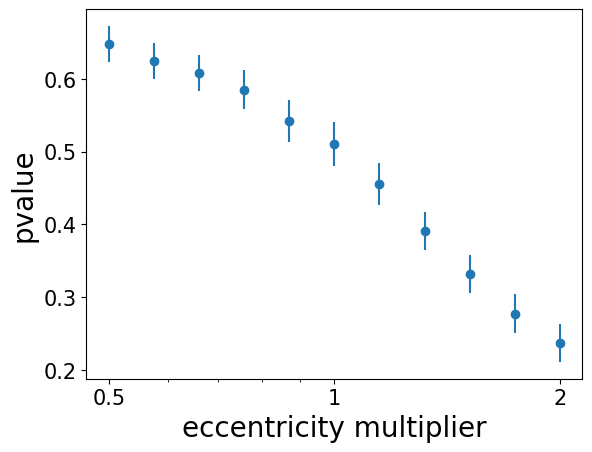

In [17]:
fig, ax = plt.subplots()
ax.errorbar(kde_changing, ecc_trials_pvalue_mean, yerr=ecc_trials_pvalue_stdev/10,fmt='o')
ax.set_xscale("log")
# plt.xticks(kde_changing)
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([.5, 1, 2], labels=[.5, 1, 2], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("pvalue", fontsize = 20)
plt.xlabel('eccentricity multiplier', fontsize = 20) 

Text(0.5, 0, 'mass multiplier')

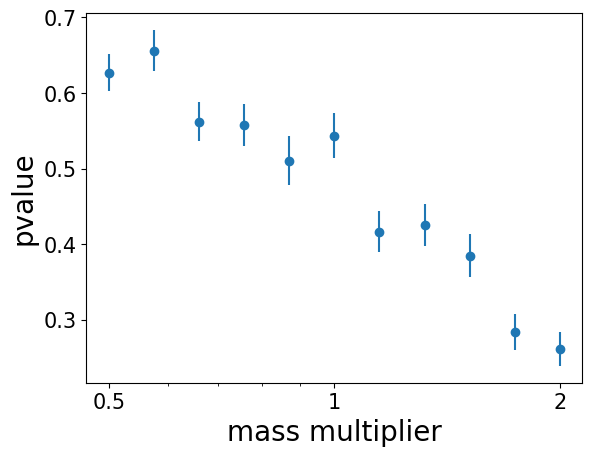

In [19]:
fig, ax = plt.subplots()
ax.errorbar(kde_changing, mass_trials_pvalue_mean, yerr=mass_trials_pvalue_stdev/10,fmt='o')
ax.set_xscale("log")
# plt.xticks(kde_changing)
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([.5, 1, 2], labels=[.5, 1, 2], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("pvalue", fontsize=20)
plt.xlabel('mass multiplier', fontsize=20) 

Text(0.5, 0, 'dispersion multiplier')

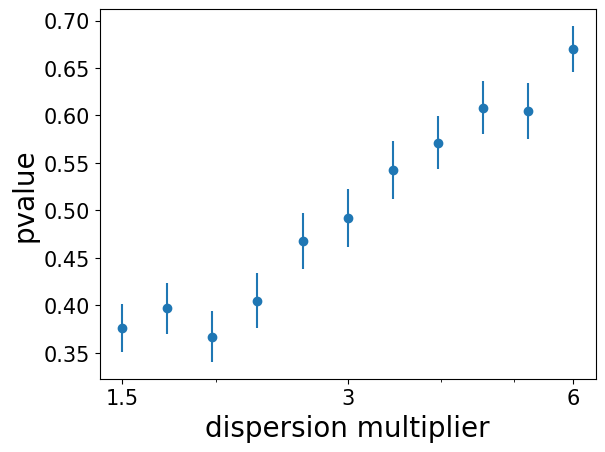

In [20]:
fig, ax = plt.subplots()
ax.errorbar(stdev_changing, disp_trials_pvalue_mean, yerr=disp_trials_pvalue_stdev/10,fmt='o')
ax.set_xscale("log")
# plt.xticks(kde_changing)
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([1.5, 3, 6], labels=[1.5, 3, 6], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("pvalue", fontsize=20)
plt.xlabel('dispersion multiplier', fontsize=20) 

# PDFs

(array([ 0.,  0.,  2.,  0.,  3.,  7.,  4.,  8.,  9., 12.,  4., 15.,  7.]),
 array([1.1       , 1.13153846, 1.16307692, 1.19461538, 1.22615385,
        1.25769231, 1.28923077, 1.32076923, 1.35230769, 1.38384615,
        1.41538462, 1.44692308, 1.47846154, 1.51      ]),
 <BarContainer object of 13 artists>)

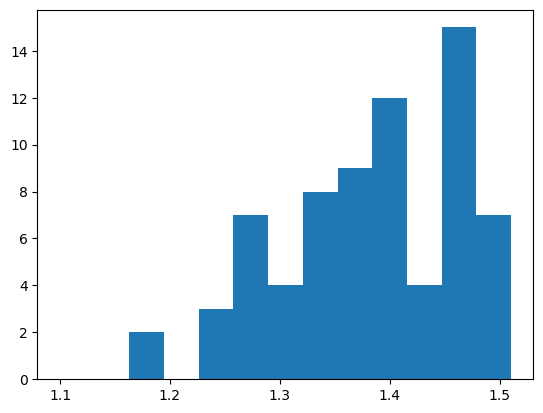

In [28]:
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, 14), color="tab:blue", label = "observed")


Text(0.5, 0, 'period ratios')

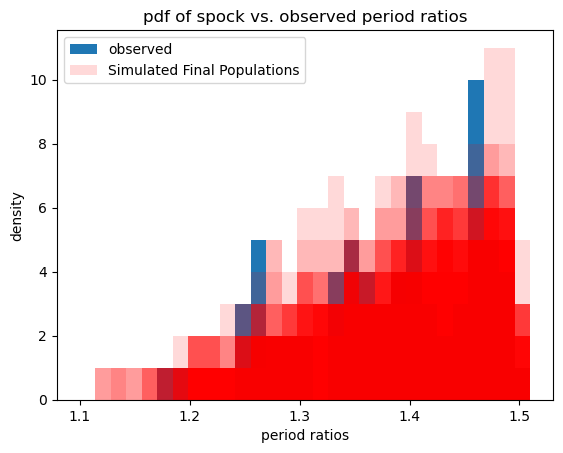

In [568]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
enum =1
for q in range(num_experiments):
    spock_p_list = trials_final_pratios[q]
    if q == 0: # add label to legend
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red", label='Simulated Final Populations')
    else:
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red")
plt.legend()
plt.ylabel("density")
plt.xlabel("period ratios")

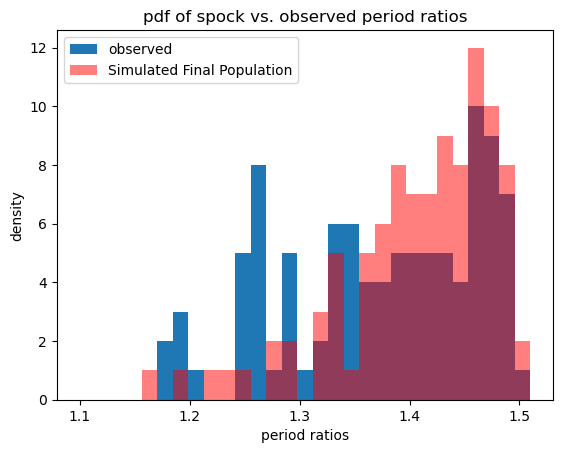

In [18]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.5, color="red", label='Simulated Final Population')
plt.ylabel("density")
plt.xlabel("period ratios")
plt.legend()

# CDFs

In [25]:
observed_period_cdf

array([0.01197865, 0.02414939, 0.03683564, 0.04958405, 0.06234081,
       0.07516692, 0.08801712, 0.10089234, 0.11378069, 0.12667226,
       0.1396868 , 0.15273107, 0.16589327, 0.17905747, 0.19232276,
       0.20565819, 0.21925305, 0.23285582, 0.24648112, 0.26011916,
       0.27379835, 0.28748172, 0.30122106, 0.31499029, 0.32879528,
       0.34263613, 0.35648976, 0.37037268, 0.38430246, 0.39827037,
       0.41224657, 0.42633758, 0.44043769, 0.45457873, 0.46872735,
       0.48291485, 0.4971885 , 0.51149135, 0.52580606, 0.54013423,
       0.55448802, 0.56884605, 0.58322962, 0.59762369, 0.61202044,
       0.62649956, 0.64103987, 0.65563687, 0.67031567, 0.68507613,
       0.69988783, 0.71471802, 0.72956972, 0.74443849, 0.75931563,
       0.77419855, 0.78908477, 0.80397158, 0.81886494, 0.83380079,
       0.84875639, 0.86374057, 0.87879461, 0.89386475, 0.90894711,
       0.92404369, 0.93916625, 0.95429561, 0.9694973 , 0.98470993,
       1.        ])

Text(0.5, 1.0, 'p-value = 0.46')

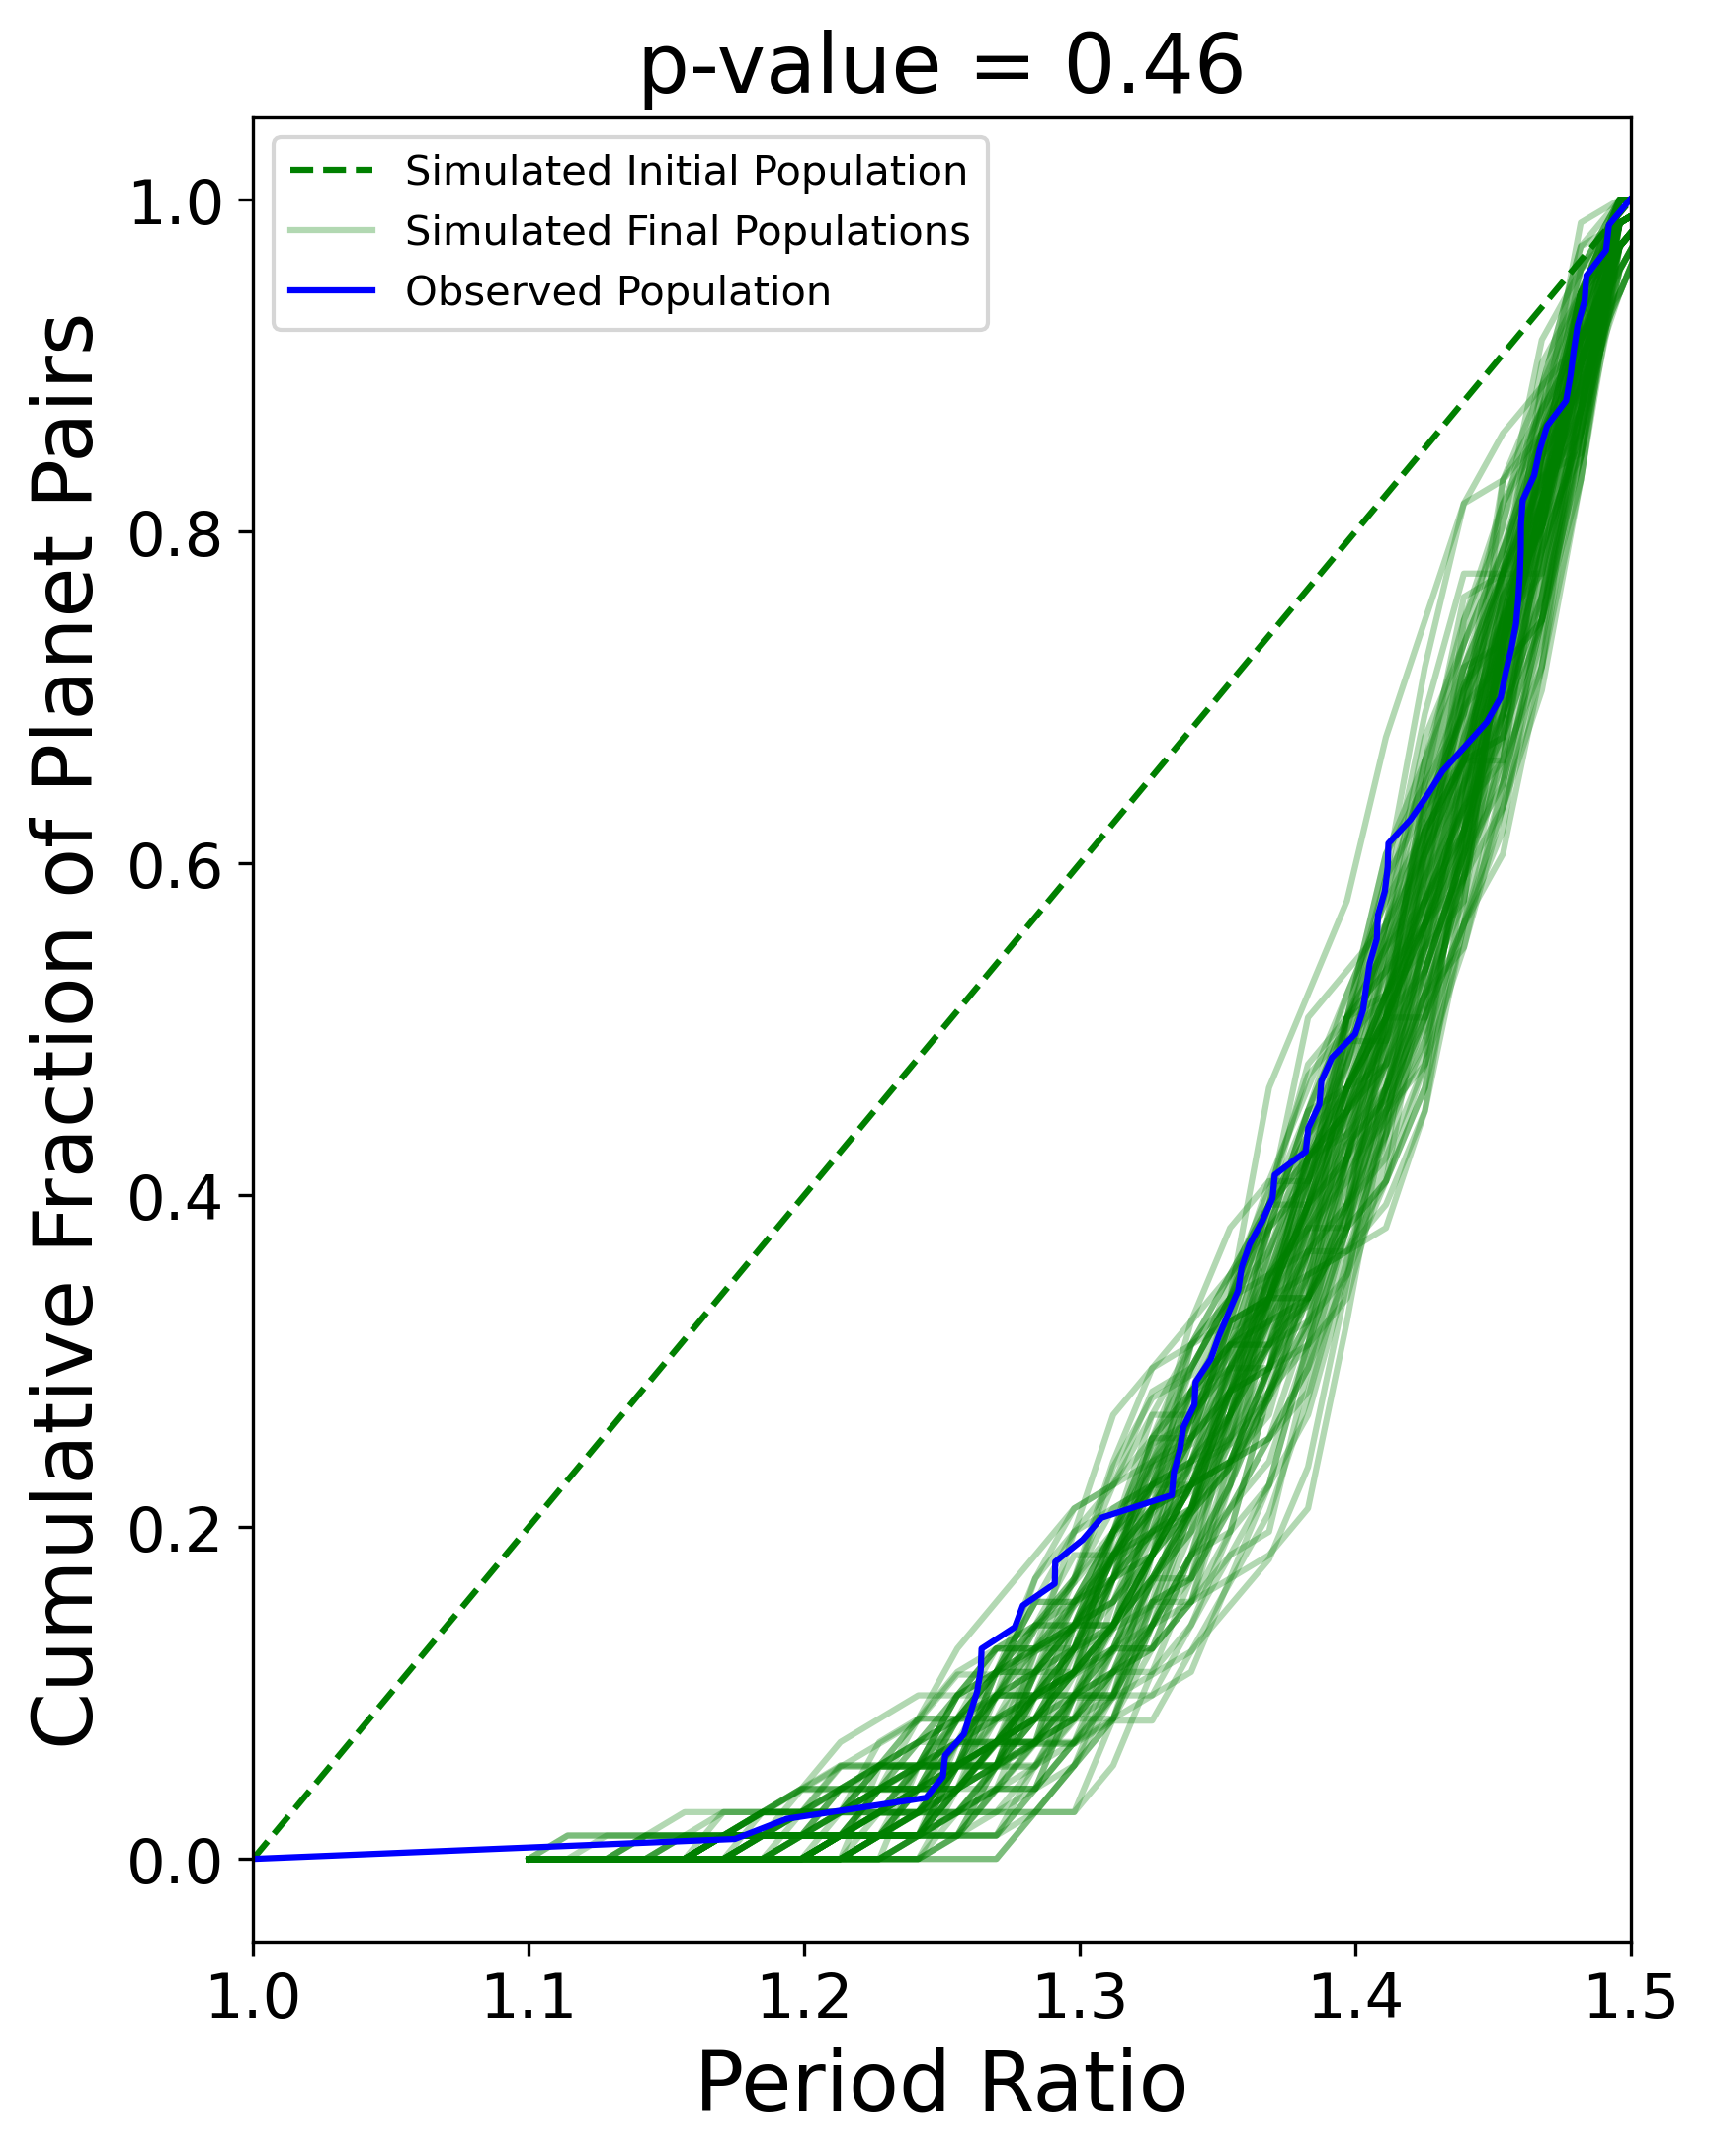

In [21]:
#Below we generate the plots for our population
#plt.style.use('./paper.mplstyle')
fig, ax = plt.subplots(figsize=(6,8), dpi=300)
enum = 6 # normal conditions at 6
ax.plot([1,1.5], [0,1], 'g--', label='Simulated Initial Population')
for q in range(num_experiments):
    spock_p_cumsum = ecc_cumsum[enum][q] #diff cumsum each time
    if q == 0:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3, label='Simulated Final Populations')
    else:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3)
        
# plot observed, don't change
ax.plot([1] + list(sorted(pratios_observed)), [0]+list(observed_period_cdf), c = 'blue', label='Observed Population')
# mmrs

# ax.axvline(1.2, color='black', linestyle='--', alpha=0.3, label = "MMR")
# ax.axvline(1.25, color='black', linestyle='--', alpha=0.3)
# ax.axvline(1.33, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.set_xlabel("Period Ratio", fontsize=20)
ax.set_ylabel("Cumulative Fraction of Planet Pairs", fontsize=20)
ax.set_xlim([1.,1.5])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('inneredge.pdf', bbox_inches='tight')
plt.title("p-value = 0.46", fontsize=20) #+ str(ecc_trials_pvalue_mean[enum])

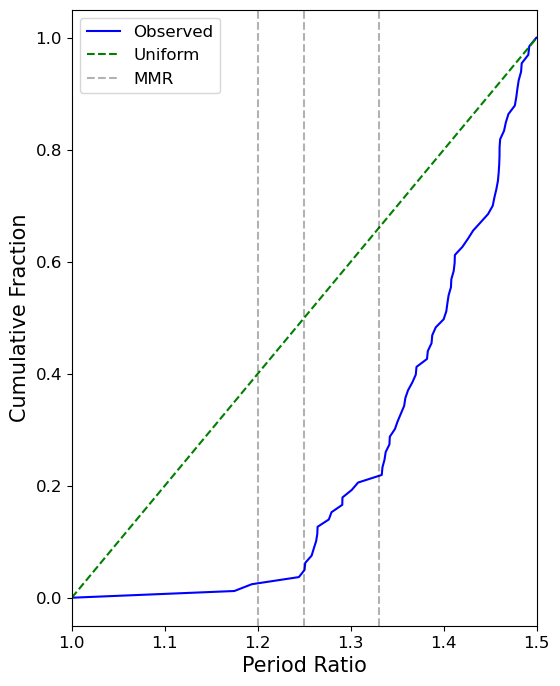

<Figure size 1000x100 with 0 Axes>

In [81]:
# literally just one experiment probs don't need?
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)

#plt.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green')
plt.plot([1] + list(pratios_observed), [0]+list(observed_period_cdf), c = 'blue')
plt.plot([1, 1.5], [0, 1], ls="--", c = 'green')
plt.axvline(1.2, color='black', linestyle='--', alpha=0.3)
plt.axvline(1.25, color='black', linestyle='--', alpha=0.3)
plt.axvline(1.33, color='black', linestyle='--', alpha=0.3)

plt.legend(["Observed", "Uniform", "MMR"], fontsize = 12)
# plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
#plt.title("p = " + '%.2E' % Decimal( str(trials_pvalue[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio", fontsize = 15)
plt.ylabel("Cumulative Fraction", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(1,1.5)
plt.figure(figsize=(10, 1))

plt.show()

In [22]:
df_all = pd.read_csv("planet_data.csv")
pratios_observed_all = []

# for every system in the dataframe with only planets with inner pratio 1.1-1.5
for system in df_all['Host Name'].unique():
    # make new df of just that system's planets
    system_df = df_all[df_all['Host Name'] == system]
    # sort least to greatest orbital period
    system_sorted = system_df.sort_values(by='Orbital Period')
    Nplanets = system_df.shape[0] # number of planets in system
    
    # for every planet pair
    for z in range(Nplanets-1):
        # find periods
        P1 = system_sorted.iloc[z]['Orbital Period']
        P2 = system_sorted.iloc[z+1]['Orbital Period']
        
        pratios_observed_all.append(P2/P1)

In [23]:
# all period ratios within df that are 1.1 - 1.5, used for CDF
pratios_observed_all = np.asarray(pratios_observed_all)
pratios_observed_all.sort()
observed_period_cdf_all = np.cumsum(pratios_observed_all)/pratios_observed_all.sum()
pratios_observed_all

array([1.02767528e+00, 1.03831507e+00, 1.17477990e+00, 1.19361856e+00,
       1.24417625e+00, 1.25027336e+00, 1.25109106e+00, 1.25789305e+00,
       1.26025515e+00, 1.26270865e+00, 1.26399713e+00, 1.26431296e+00,
       1.27637229e+00, 1.27928855e+00, 1.28658380e+00, 1.29085400e+00,
       1.29105027e+00, 1.30096463e+00, 1.30784238e+00, 1.32557665e+00,
       1.33328639e+00, 1.33383484e+00, 1.33406214e+00, 1.33627126e+00,
       1.33642463e+00, 1.33752100e+00, 1.34155768e+00, 1.34196578e+00,
       1.34571219e+00, 1.34602469e+00, 1.34745650e+00, 1.35038696e+00,
       1.35389430e+00, 1.35741159e+00, 1.35866415e+00, 1.35961237e+00,
       1.36153757e+00, 1.36613220e+00, 1.36987246e+00, 1.37068514e+00,
       1.38194556e+00, 1.38283711e+00, 1.38685146e+00, 1.38759517e+00,
       1.39140811e+00, 1.39985744e+00, 1.40272050e+00, 1.40388468e+00,
       1.40520358e+00, 1.40771659e+00, 1.40813270e+00, 1.40957155e+00,
       1.41063722e+00, 1.41166672e+00, 1.41193039e+00, 1.42000817e+00,
      

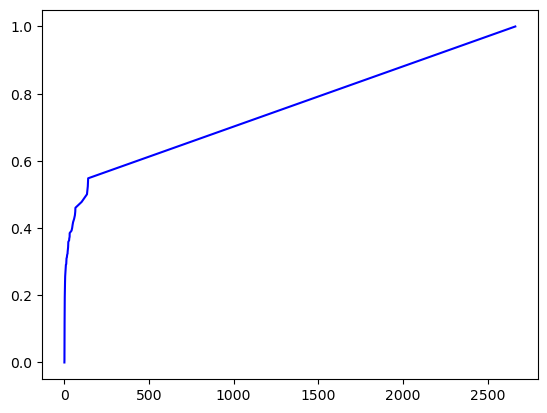

In [26]:
plt.plot([1] + list(pratios_observed_all), [0]+list(observed_period_cdf_all), c = 'blue')

# KDEs with SPOCK

In [35]:
# Create a histogram of the original data
n, bins_e, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid_e, kde_e(x_grid_e), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(e_list, bins=bins_e, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples, e_list spock selected from
kde_new_e = gaussian_kde(e_list)
plt.plot(x_grid_e, kde_new_e(x_grid_e), label='Population KDE')

#plot the actual eccentricities spock took
n_s_new, bins_s_new, patches_s_new = plt.hist(spock_e_list, bins=bins_e, histtype='step', density=True, label = 'Spock Population')
kde_s_new = gaussian_kde(spock_e_list)
plt.plot(x_grid_e, kde_s_new(x_grid_e), label='Spock Population KDE')


# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Eccentricity Distribution via KDE Estimation")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()

NameError: name 'eccentricity' is not defined

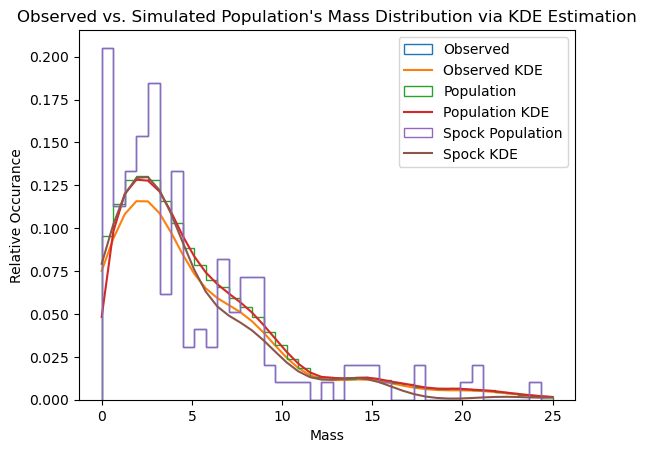

In [188]:
#masses after spock
# Create a histogram of the original data
n, bins, patches = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples, m_list spock selected from
n_new, bins_new, patches_new = plt.hist(m_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(m_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')

#plot spock mass distribution
ns, binss, patchess = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Spock Population')
kdes=gaussian_kde(spock_m_list)
plt.plot(x_grid, kdes(x_grid), label='Spock KDE')

# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Mass Distribution via KDE Estimation")
plt.xlabel("Mass")
plt.ylabel("Relative Occurance")
plt.legend()


# Show the plot
plt.show()

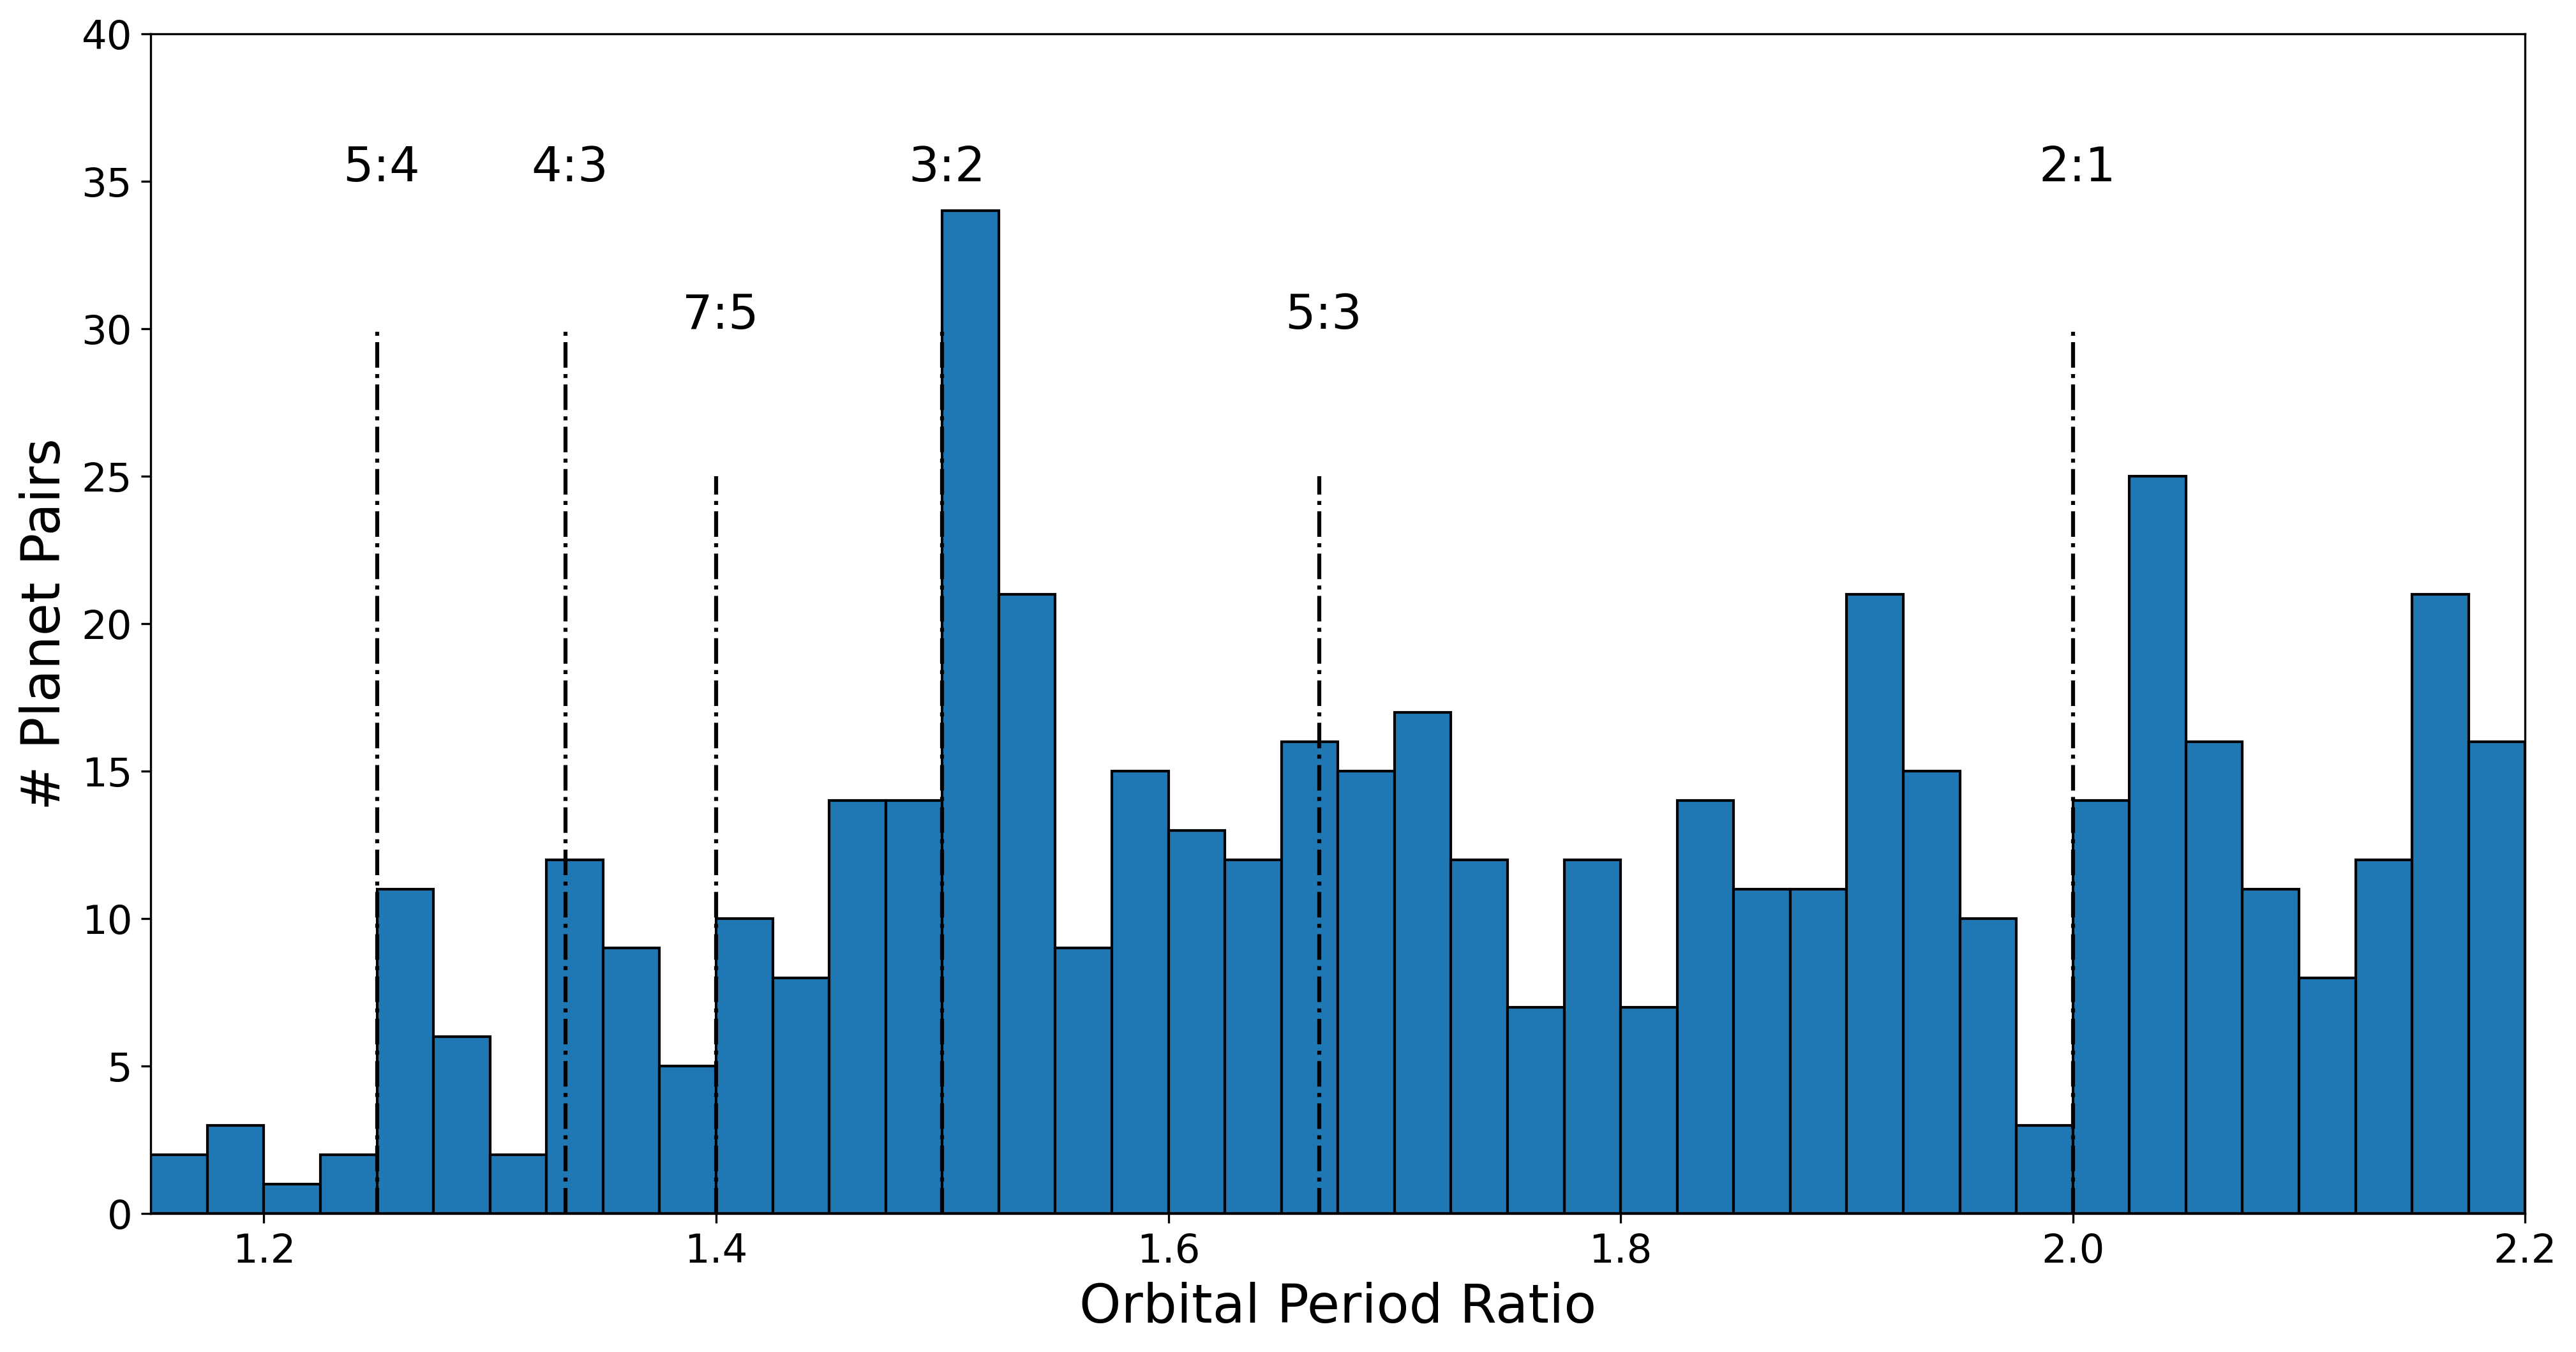

In [110]:
import pandas as pd
pairs = pd.read_csv('exoarchive_planet_pairs.csv', index_col=0)
fig, ax = plt.subplots(figsize=(16,8), dpi = 300)
ax.hist(pairs['Pratio'], bins=np.linspace(1.15, 3.25, 85), ec='k')
ax.set_xlabel('Orbital Period Ratio', fontsize = 20)
ax.set_ylabel('# Planet Pairs', fontsize = 20)
resonances = [(2,1), (5,2), (3,1), (7,2), (4,1), (5,1)]
for j,k in resonances:
    Pres = j/(j-k)
    if k == 1:
        ax.plot([Pres, Pres], [0, 30], linestyle='-.', color='k')
        ax.text(Pres-0.015, 35, '{0}:{1}'.format(j, j-k), fontsize=18)
    else:
        ax.plot([Pres, Pres], [0, 25], linestyle='-.', color='k')
        ax.text(Pres-0.015, 30, '{0}:{1}'.format(j, j-k), fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim([0, 40])
ax.set_xlim([1.15, 2.2])
fig.savefig('mmrs.pdf', bbox_inches='tight')

In [109]:
pairs

,hostname,pair,Pratio,j,k,Pres,Delta
25,24 Sex,bc,1.950088,2,1,2.0,-0.024956
43,47 UMa,bc,2.207349,2,1,2.0,0.103674
46,47 UMa,cd,5.856127,3,2,3.0,0.952042
83,55 Cnc,eb,19.891345,3,2,3.0,5.630448
55,55 Cnc,bc,3.029056,3,2,3.0,0.009685
...,...,...,...,...,...,...,...
26240,rho CrB,bc,2.573421,3,2,3.0,-0.142193
26249,tau Cet,gh,2.470500,2,1,2.0,0.235250
26250,tau Cet,he,3.296296,3,2,3.0,0.098765
26247,tau Cet,ef,3.905753,3,2,3.0,0.301918
